### Notes 
 - each x/y position in K-space gets mapped to a new position
     - original (if no movement) OR new position
     
     - To do:
         - method for computing new position f(x,y)
     
 - once a coordinate is seen, it is never revisted in K-space trajectory
 
 - position experiences shift in X and / or shift in Y, which translates into a shift in K-space
     - if shift occurs at a specific coordinate, this updates the observed down-stream K-space pattern
     
### Motion is dependent on the phase-encoding direction

 - how we apply the shift for X and Y motion will depend on the K-space trajectory
 - here assume the phase-encode direction is in **A-P direction**

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np

def mapping(coordinates, translation, size):
    
    """
    Translate a coordinate, based on observed motion pattern.
    
    Parameters:
    - - - - -
    coordinate: array of ints, N-coordinates x 2
        input coordinate to translate
    translation: array of ints, 1x2
        input translations for each dimension
    size: array of ints, 1x2
        Fourier domain size
        
    Return:
    - - - -
    [x, y]: array of ints
        mapped coordinates
    
    Examples:
    - - - - -
    coordinates = np.array([0, 0])
    translation = np.array([1, 1])
    size = np.array([4, 4])
    
    print(mapping(coordinates, translation, size))
    array([1,1])
    
    coordinates = np.array([1, 1])
    translation = np.array([2, 2])
    size = np.array([4, 4])
    
    print(mapping(coordinates, translation, size))
    array([3, 3])
    
    """
    
    # initialize translated coordinates array
    translated = np.zeros((coordinates.shape))
    # get number of coordinates, input image size, and translations
    [R, _] = coordinates.shape
    [sx, sy] = size
    [tx, ty] = translation
    
    # get original x and y coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    
    # round movement to nearest integer
    # Notes:
    # bilinear interpolation method??
    x = np.round(x+tx)
    y = np.round(y+ty)
    
    # define boundaries of coordinate shifts
    if tx < 0:
        x = np.maximum(0, x)
    else:
        x = np.minimum(sx-1, x)
    
    if ty < 0:
        y = np.maximum(0, y)
    else:
        y = np.minimum(sy-1, y)

    translated[:, 0] = x
    translated[:, 1] = y
        
    return np.int32(translated)


"""
def fourier_shift(signal, order, shiftx, shifty):

    Shift the K-space signal of an MRI slice.
    
    Parameters:
    - - - - - -
    signal: array, float
        input image
    order: list
        traversal order of pixel indices, analogous to the 
        K-space trajectory
    shiftx: array, float
        motion in x direction.  Same size as ```signal```.
        Each position experiences a potentially non-zero shift.
    shifty: array, float
        motion in y direction.  Same size as ```signal```.  
        Each position experiences a potentially non-zero shift.
        
    Returns:
    - - - - 
    motion: array, float
         spatial-domain signal with motion applied
    motion_fft: array, float
        frequency-domain signal with motion applied
        
    While the shifts in the x and y directions can theoretically be floats,
    here we make the assumption that motion occurs in discrete intervals.  
    If the degree of motion is a fraction of a pixel, we round to nearest int.

    ordr = list(order.copy())
    
    # Apply 2D-Fourier transform and shift k-space signal
    fft = np.fft.fft2(signal)
    fft_s = np.fft.fftshift(fft)

    [n, p] = fft_s.shape

    motion_fft = fft_s.copy()
    
    # Loop over indices in order
    while len(ordr) > 0:
        
        # convert indices to x-y coordinate pairs
        coords = np.column_stack(np.unravel_index(ordr,(n,p)))
        [cx,cy] = coords[0, :]
        
        # get motion for current index
        trans_l = np.array([shiftx[cx, cy],
                            shifty[cx, cy]])

        # if motion in either x or y direction
        # apply shift to all coordinates
        if np.any(trans_l):

            # compute coordinate transforms
            mpc = mapping(coords, trans_l, np.array([n, p]))
        
            # update k-space information with new coordinates
            motion_fft[coords[:, 0], coords[:, 1]] = motion_fft[mpc[:, 0],
                                                  mpc[:, 1]]

        ordr.pop(0)

    motion_ffts = np.fft.ifftshift(motion_fft)
    motion = np.abs(np.fft.ifft2(motion_ffts))
    
    return [motion, motion_fft]
"""
        
    
def fourier_shift(signal, order, shiftx, shifty, xcoords, ycoords):
    
    """
    Shift the K-space signal of an MRI slice.
    
    Parameters:
    - - - - - -
    signal: array, float
        input image
    order: list
        traversal order of pixel indices, analogous to the 
        K-space trajectory
    shiftx: array, float
        motion in x direction.  Same size as ```signal```.
        Each position experiences a potentially non-zero shift.
    shifty: array, float
        motion in y direction.  Same size as ```signal```.  
        Each position experiences a potentially non-zero shift.
    xcoords: list, int
        indices where motion occurs in x-direction
    ycoords: list, int
        indices where motion occurs in y-direction
        
    Returns:
    - - - - 
    motion: array, float
         spatial-domain signal with motion applied
    motion_fft: array, float
        frequency-domain signal with motion applied
        
    While the shifts in the x and y directions can theoretically be floats,
    here we make the assumption that motion occurs in discrete intervals.  
    If the degree of motion is a fraction of a pixel, we round to nearest int.

    """
    
    motion_coords = np.unique(np.concatenate([xcoords,ycoords]))
    
    ordr = list(order.copy())
    
    # Apply 2D-Fourier transform and shift k-space signal
    fft = np.fft.fft2(signal)
    fft_s = np.fft.fftshift(fft)

    [n, p] = fft_s.shape

    motion_fft = fft_s.copy()
    
    # Loop over indices in order
    for m in motion_coords:
        
        # convert indices to x-y coordinate pairs
        coords = np.column_stack(np.unravel_index(ordr[m:],(n,p)))
        [cx,cy] = coords[0, :]
        
        # get motion for current index
        trans_l = np.array([shiftx[cx, cy],
                            shifty[cx, cy]])

        # if motion in either x or y direction
        # apply shift to all coordinates
        if np.any(trans_l):

            # compute coordinate transforms
            mpc = mapping(coords, trans_l, np.array([n, p]))
        
            # update k-space information with new coordinates
            motion_fft[coords[:, 0], coords[:, 1]] = motion_fft[mpc[:, 0],
                                                  mpc[:, 1]]

    motion_ffts = np.fft.ifftshift(motion_fft)
    motion = np.abs(np.fft.ifft2(motion_ffts))
    
    return [motion, motion_fft]

### Load and prepare data

(260, 311, 260)


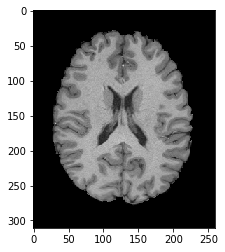

In [3]:
import nibabel as nb

# b0 volume file
t1_file = '/Users/kristianeschenburg/Desktop/Research/Data/Structural/285345.T1w_restore_brain.nii.gz'
t1 = nb.load(t1_file)

data = t1.get_data()
print(data.shape)

img = data[:, :, 130];
img = np.flipud(img.T);
plt.imshow(img, cmap='gray');

In [4]:
def kspace_trajectory(n, p):
    
    """
    Generate the K-space trajectory of visited voxels.
    
    Parameters:
    - - - - -
    n: int
        number of rows in input image
    p: int
        number of columns in input image
    """
    
    order = np.arange(n*p)
    
    for i in np.arange(1, p, 2):
        
        lo = i*p
        hi = (i+1)*p
        
        order[lo:hi] = np.flip(order[lo:hi], axis=0)
        
    return order

In [5]:
# compute order of visited voxels
order = kspace_trajectory(img.shape[0], img.shape[1])

In [6]:
# load motion parameters from fMRI MCFLIRT

import pandas as pd
from scipy.stats import multivariate_normal

prefilt = '/Users/kristianeschenburg/Documents/Code/DeepImageRecon/data/prefiltered_func_data_mcf.par'
df = pd.read_table(prefilt,names=['xrad', 'yrad', 'zrad',
                                  'xshift', 'yshift', 'zshift'],
                   sep='\s+')

In [7]:
from scipy.stats import multivariate_normal as MVN

def sample_motion(n_samples, indices, motion_df, img, xweight=None, yweight=None):
    """
    Sampel x and y motion for multivariate normal distribution.
    
    Parameters:
    - - - - -
    n_samples: int
        number of samples to generate
    indices: int, array
        indices to apply motion to
    motion_df: Pandas data frame
        data frame of sampled motion to fit 6d-Gaussian to
        expected column names: 'xrad', 'yrad', 'zrad'
                               'xshift', 'yshift', 'zshift'
    img: float, array
        input image
    xweight: float
        weight to apply to xmotion
    yweight: float
        weight to apply to ymotion
    """

    # get input image dimensions
    [n, p] = img.shape
    
    # get weights for each axis of motion
    if not xweight:
        xweight = 1
    if not yweight:
        yweight = 1

    # fit distribution from which to sample motion from
    mu = motion_df.mean(0)
    cov = motion_df.cov()
    gauss = MVN(mean=mu, cov= cov)

    # sample positions in K-space tracjectory for when
    # motion occurs in X and Y directions
    inds = np.random.choice(indices, size=n_samples, replace=False)
    inds = np.column_stack(np.unravel_index(inds, (n, p)))

    # sample motion for each coordinate
    samples = pd.DataFrame(
            gauss.rvs(size=n_samples),
            columns=motion_df.columns)

    x_motion = np.zeros((n, p))
    x_motion[inds[:, 0], inds[:, 1]] = xweight*np.asarray(samples['xshift'])
    
    x_coords = np.ravel_multi_index(np.where(x_motion!=0), x_motion.shape)

    y_motion = np.zeros((n, p))
    y_motion[inds[:, 0], inds[:, 1]] = yweight*np.asarray(samples['yshift'])
    
    y_coords = np.ravel_multi_index(np.where(y_motion!=0), y_motion.shape)


    return [x_motion, x_coords, y_motion, y_coords]

In [8]:
def plot_synthetic(original, synthetic, figsize):
    
    """
    Plot original image, synthetic data, and difference.
    
    Parameters:
    - - - - -
    original: float, array
        original clean image slice
    synthetic: float, array
        synthetic, motion-corrupted image
    figsize: int, tuple
        size of figures
    """
    
    difference = original - synthetic
    
    fig, [ax1, ax2, ax3] = plt.subplots(1,3,figsize=figsize)
    
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Slice', fontsize=15)
    
    ax2.imshow(synthetic, cmap='gray')
    ax2.set_title('Synthetic Motion', fontsize=15)
    
    ax3.imshow(difference, cmap='gray')
    ax3.set_title('Difference', fontsize=15)
    
    
def plot_motion_events(xmotion, ymotion, figsize):
    
    """
    Plot locations of motion in K-space.
    
    Parameters:
    - - - - -
    xmotion: float, array
        x-motion events
    ymotion: float, array
        y-motion events
    figsize: int, tuple
        size of figures
    """
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=figsize);
    
    ax1.spy(xmotion != 0, marker='o');
    ax1.set_title('X-Motion, K-Space', fontsize=15);
    
    ax2.spy(ymotion != 0, marker='o');
    ax2.set_title('Y-Motion, K-Space', fontsize=15);

### 5 events in X / Y directions

X motion min/max: -5.162294251167408 / 3.337811478131788
Y motion min/max: -16.558717443022665 / 11.53672267616009


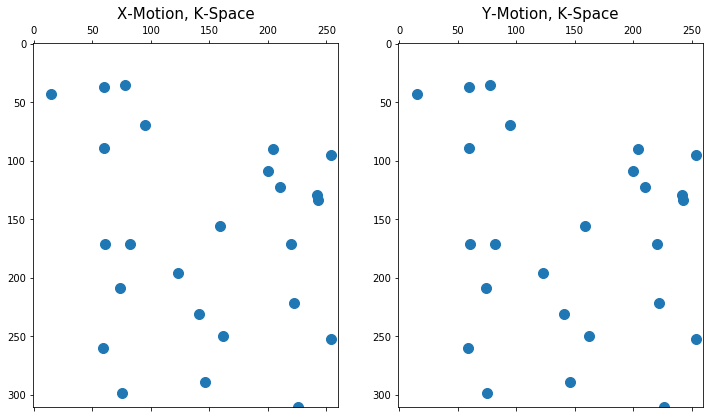

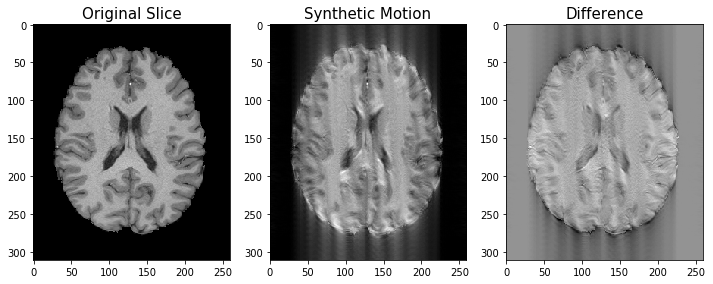

In [9]:
# 5 events, xweight=25, yweight=5
[xm, xc, ym, yc] = sample_motion(25, np.asarray(order), df, img, xweight=25, yweight=25)

print('X motion min/max: {:} / {:}'.format(xm.min(), xm.max()))
print('Y motion min/max: {:} / {:}'.format(ym.min(), ym.max()))

# plot motion events
plot_motion_events(xm, ym, (12,8))

# compute synthetic motion
[motion, motion_fft] = fourier_shift(signal=img, order=order, shiftx=xm, shifty=ym, 
                                       xcoords=xc, ycoords=yc)

# plot motion
plot_synthetic(img, motion, (12,8))